In [1]:
!pip install "preliz[full,notebook]"
import preliz as pz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.2/514.2 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: nbclient
    Found existing installation: nbclient 0.10.0
    Uninstalling nbclient-0.10.0:
      Successfully uninstalled nbclient-0.10.0


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm
import arviz as az

For this project I am using the given data. I am doing ths for two reasons

1. I dont fully understand this unit as well as I would have liked to make an interesting project with an interesting data set.

2. Even if I wanted to take time to understand and then make an original project, I don't think I would hve enough time.

So anayway, onto my question... What is the average number of total rebounds (TRB) based on player postition (POS) for the 2023-2024 NBA season players?

**Data**

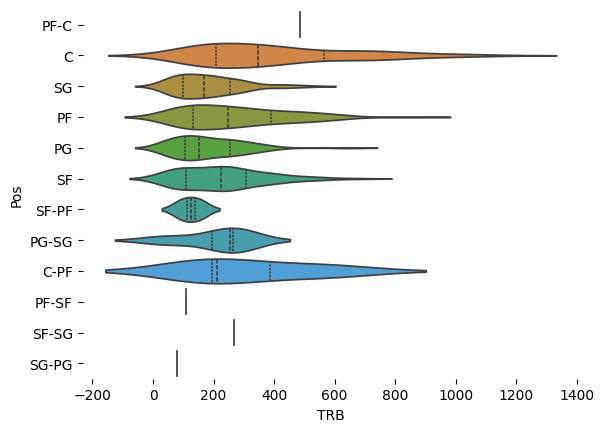

In [30]:
# I'm starting by loading in my data
url_data = 'https://raw.githubusercontent.com/rithisenthil/DSF_Submission_Files/refs/heads/main/U4Proj.csv'
OGdata = pd.read_csv(url_data)

# Remove most of the players who have less than 300 minutes played, so that it rremove most eople who scores 0 rebounds
data = OGdata.query('MP >= 300')

#A visualization of the distribution of TRB per postition
sns.violinplot(data, x='TRB', y='Pos', inner='quart', hue='Pos')
sns.despine(top=True, right=True, bottom=True, left=True)




A couple interesting things that I am noticing here

1. The combo postitions (ex. PF-SF) sometimes have a tiny tiny distribution, this is leading me to beleive that either these postitions score almost indentical TRB numbers, or therre is only one person who has his specific postition combo
2. Other than the combo postitions, theere are two major outliers in the data. The centers, who are scoring a lot more rebounds than everyone else, and the shooting guard who is score less than everone else.

I think it will be important to keep these things in mind when choosing a prior, and making improvemnts to my models.

In [31]:
pos_encode = pd.Categorical(data['Pos'])
pos_idx = pos_encode.codes
pos_coords = {"Pos": pos_encode.categories}

In [32]:
with pm.Model(coords = pos_coords) as bball_model:

# Hyper Prior
    μ = pm.Beta('μ', alpha = 2, beta = 13)
    ν = pm.Gamma('ν', mu = 100, sigma = 50)

# Prior
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "Pos")

    ν_p = pm.Gamma('ν_p', mu = 200, sigma = 45, dims="Pos")

# Likelihood
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

# Model time!
    calculations = pm.Binomial('gs',
                    n = data.TRB.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = data.TRB.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_bball = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:There were 1993 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([<Axes: >], dtype=object)

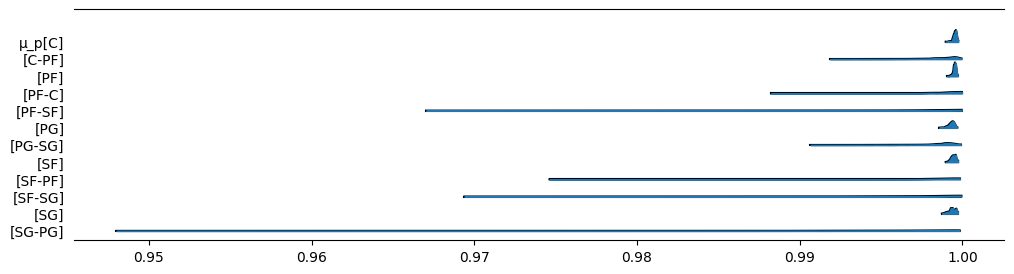

In [33]:
az.plot_forest(idata_bball, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

Woah, what happened here? Well, the first thing I noticed was that the domain of these values only went from 0-1. This tells me that the model is trying to make my data into a percentage of some sort? Probably because I am using Bernoulli distribution. Next, I tried again with a studentT one.

In [34]:
with pm.Model(coords=pos_coords) as bball_model_v2:

# hyper priors for the mean (mu)
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

# priors
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "Pos")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "Pos")

    ν = pm.Normal('ν',
                  mu = 20,
                  sigma = 10,
                  dims = "Pos")

  # likelihood, but this time i am using StudentT
    y = pm.StudentT('y',
                  mu = μ[pos_idx],
                  sigma = σ[pos_idx],
                  nu = ν[pos_idx],
                  observed = data.TRB.values)

  # v2, bc this is the second iteration
    idata_bball_v2 = pm.sample()

Output()

Output()

ERROR:pymc.stats.convergence:There were 707 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([<Axes: >], dtype=object)

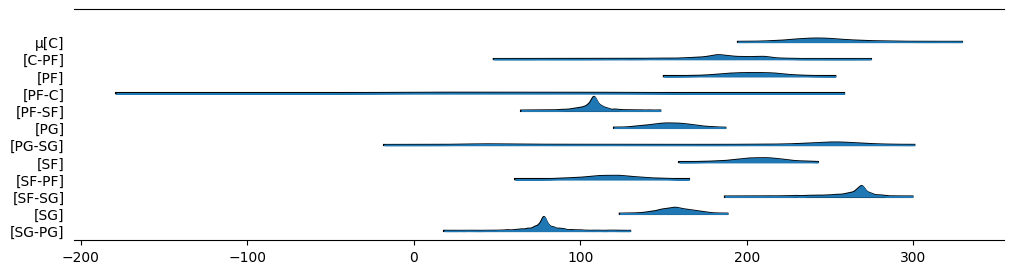

In [35]:
az.plot_forest(idata_bball_v2, var_names=['μ'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

This makes a little more sense. You can see that for the postitions with less data (the combo ones), the distruibutions are either incredibly wide, or narrow with a single hhigh point. This is probably because these postitionns either have very few spaced apart values, or only 1 or 2 very similar values. The other five single postitions seem to have pretty reasonabe graphs

Output()

(0.0, 1000.0)

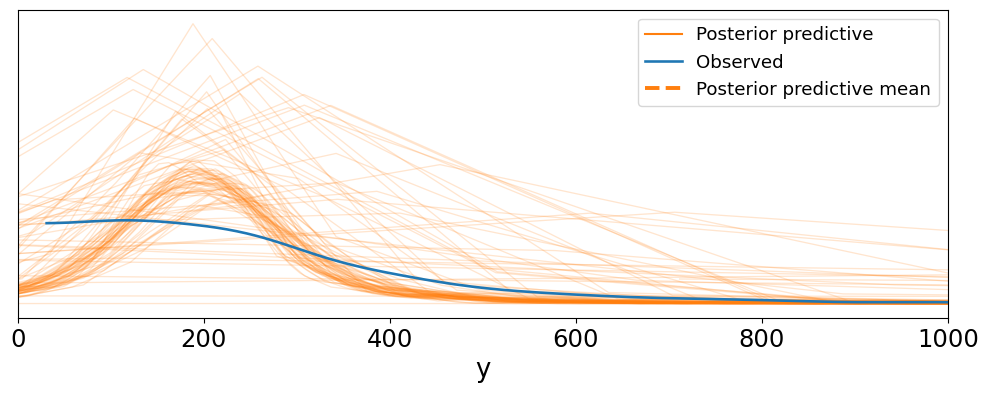

In [39]:
pm.sample_posterior_predictive(idata_bball_v2, model=bball_model_v2, extend_inferencedata=True)

ax=az.plot_ppc(idata_bball_v2, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim([0, 1000])


Ok, let's take a step back. The model works (?), but not very well at all. if I were to try and indentify the biggest problems they would be these:

1. Keeping all of the combo postitions-

     While I by no means think that this was the primary reson for my models failure, I beleive it would have worked much better if I had just isolated the 5 main postitions. This is probably because there were so many outliers that just made my data "messy", and made it hard to for my choose my priors and hyperpriors (which segways right into my next reason).

2. Not choosing good priors and hyper priors-

     In my opinion, this is the biggest reason for the failure of my model. This is most probably due to two main reasons
     - Not being familiar with this context
     - Not having enough time
     I am not a big basketball watcher, I know enough to get through some small talk and not make a fool of myself, but defenitley not enough to make some guesses about the amount of total rebounds scored by different postitions. I also think I may have made my priors too strongs, especially for someone who knows nothing about the context they were making the priors for. I probably could have gottten around this if I had had enough time to play around with the numbers, but since this project had such a fast turnaround there there wasn't enough time for me to experiment.

3. So many divergences :( -

    Not sure what I would have done about these, Im guessing the were a result of the messy data. With more time I probably would have looked further into them.

array([[<Axes: title={'center': 'μ\nC'}>,
        <Axes: title={'center': 'μ\nC-PF'}>,
        <Axes: title={'center': 'μ\nPF'}>,
        <Axes: title={'center': 'μ\nPF-C'}>],
       [<Axes: title={'center': 'μ\nPF-SF'}>,
        <Axes: title={'center': 'μ\nPG'}>,
        <Axes: title={'center': 'μ\nPG-SG'}>,
        <Axes: title={'center': 'μ\nSF'}>],
       [<Axes: title={'center': 'μ\nSF-PF'}>,
        <Axes: title={'center': 'μ\nSF-SG'}>,
        <Axes: title={'center': 'μ\nSG'}>,
        <Axes: title={'center': 'μ\nSG-PG'}>],
       [<Axes: title={'center': 'μ_mu'}>,
        <Axes: title={'center': 'μ_sd'}>,
        <Axes: title={'center': 'ν\nC'}>,
        <Axes: title={'center': 'ν\nC-PF'}>],
       [<Axes: title={'center': 'ν\nPF'}>,
        <Axes: title={'center': 'ν\nPF-C'}>,
        <Axes: title={'center': 'ν\nPF-SF'}>,
        <Axes: title={'center': 'ν\nPG'}>],
       [<Axes: title={'center': 'ν\nPG-SG'}>,
        <Axes: title={'center': 'ν\nSF'}>,
        <Axes: title={'c

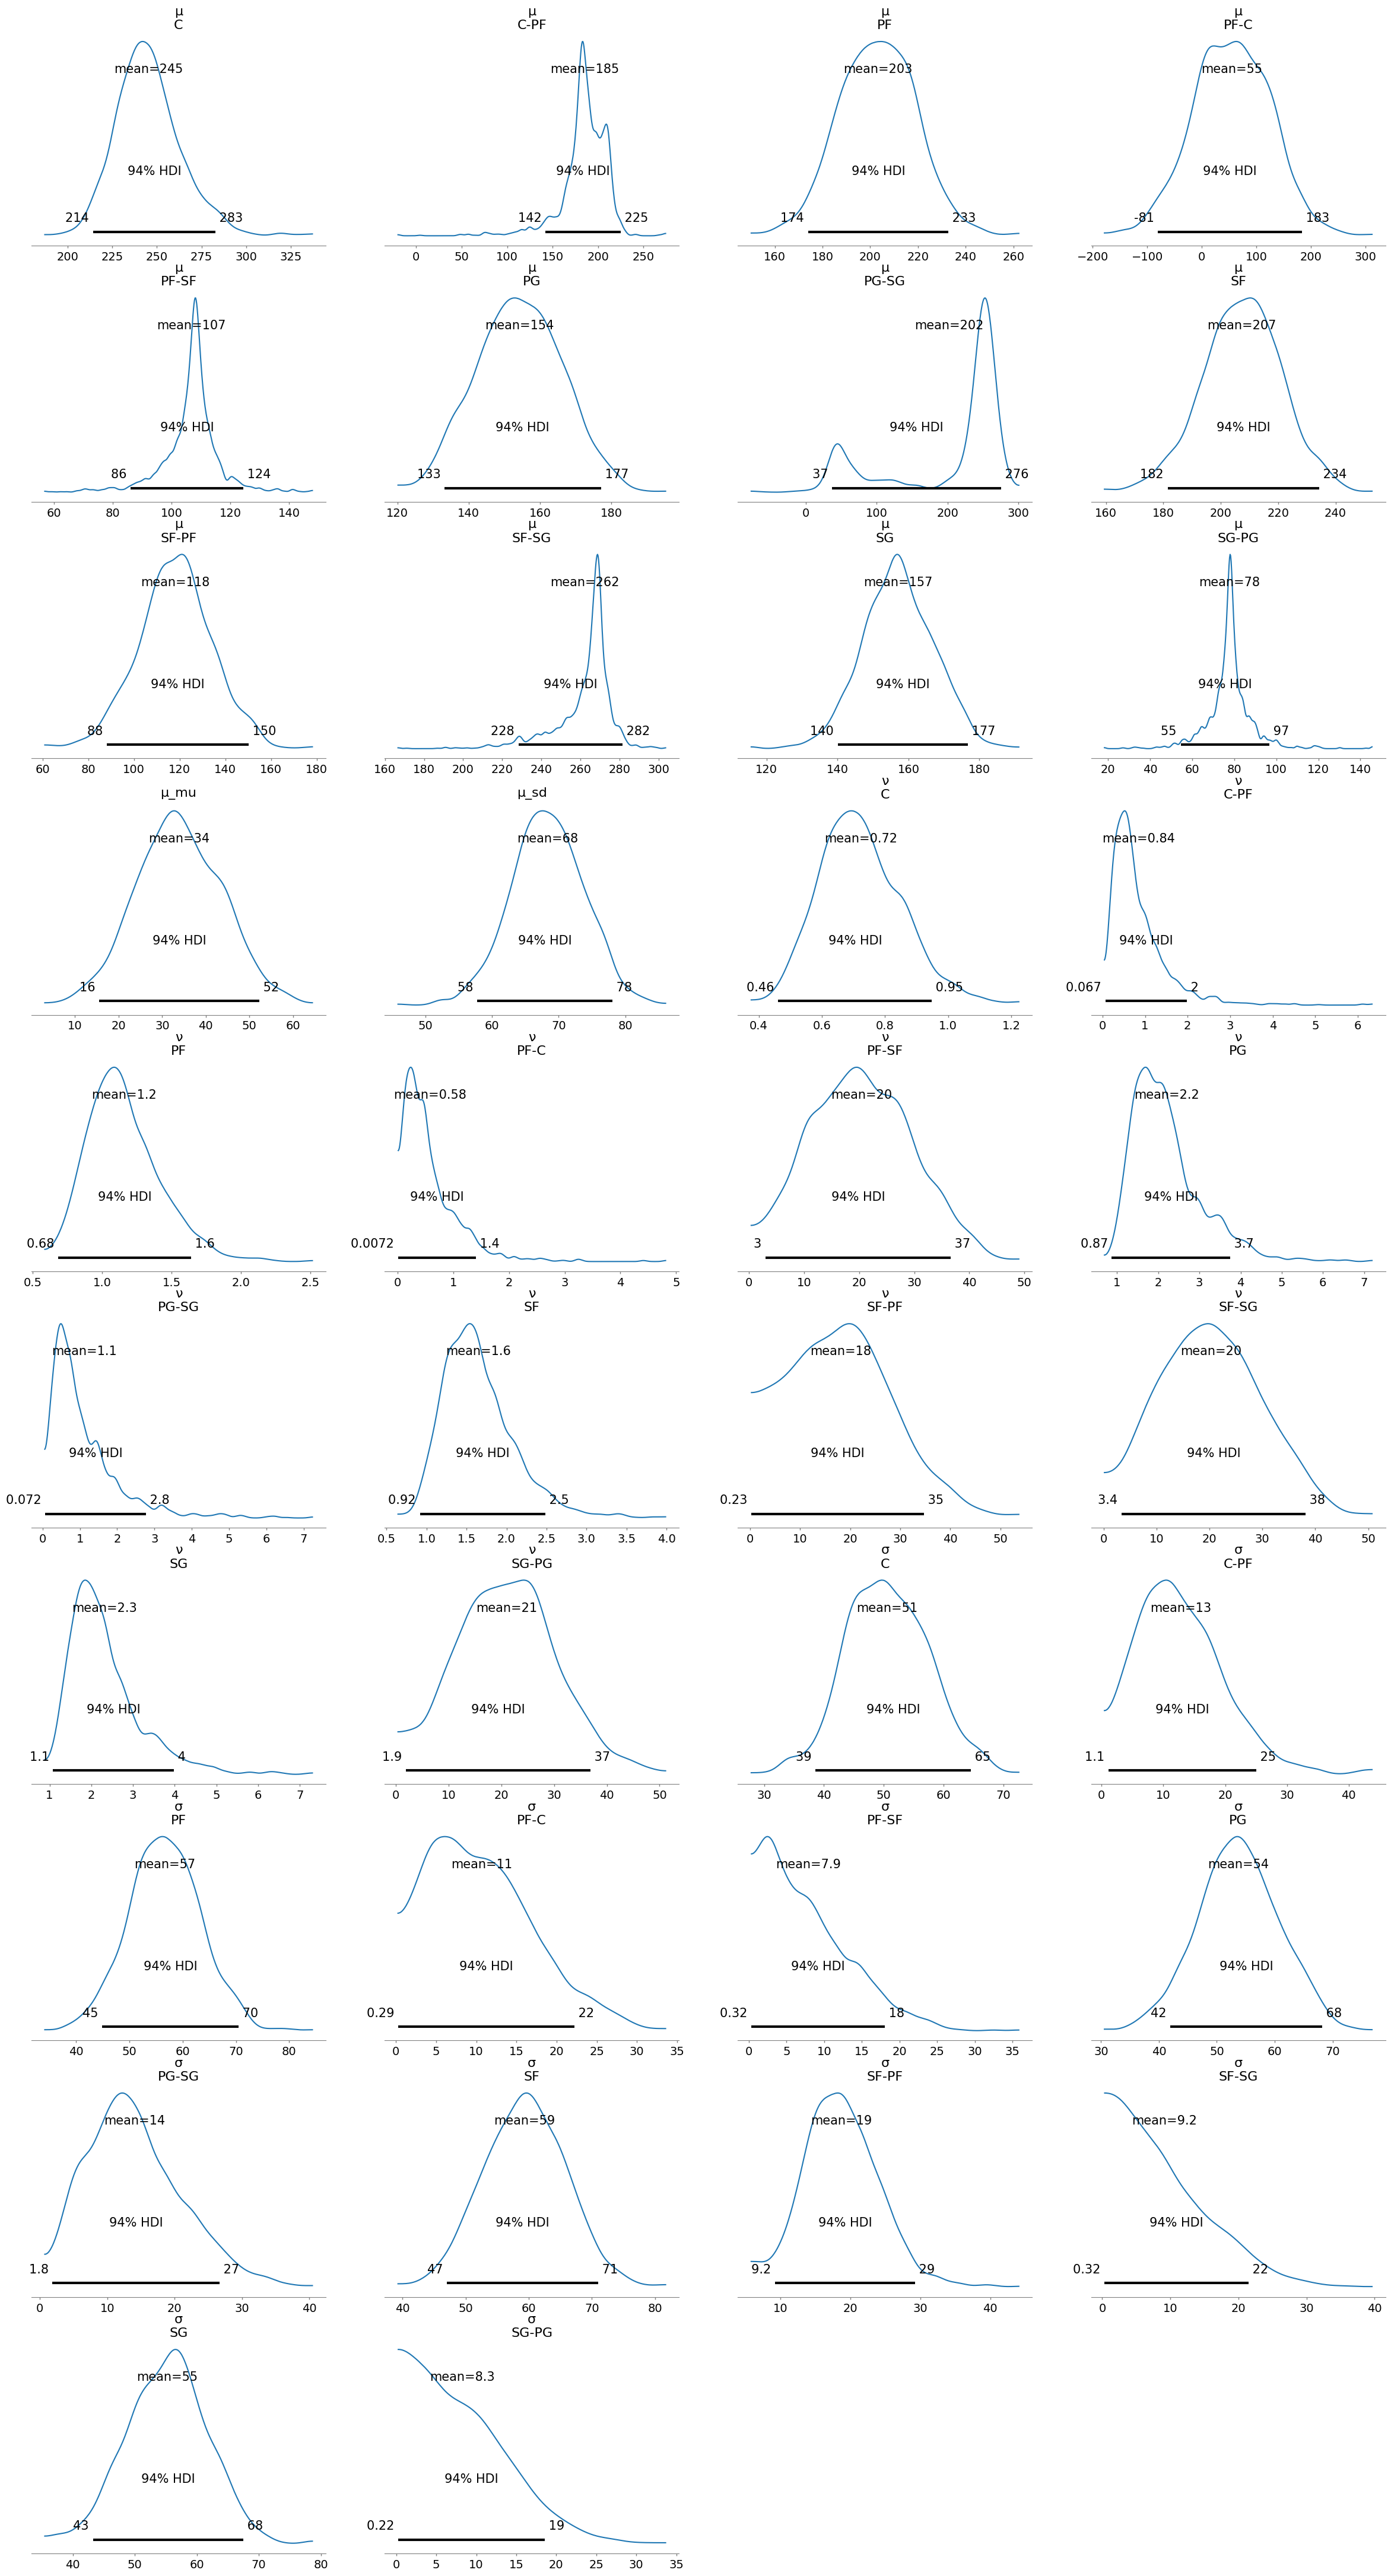

In [41]:
 az.plot_posterior(idata_bball_v2)

This is just a fun little experiment I tried to try to visualize why my priors didnt fit.